<h1 style="font-family: monospace; color: orange; text-align: center; font-size: 50px;"> 
    Poker Player Patterns
</h1><br />

The data needed is [here](https://www.kaggle.com/smeilz/poker-holdem-games#Export%20Holdem%20Manager%202.0%2012292016131233.txt), specific file used is 
<span style="color: black; color: orange; font-weight: bold;">
    Export Holdem Manager 2.0 12302016144830.txt
</span>.
<br />
It represents a game of over 40 000 rounds played on a table with real money (prbbly in dolars).

## Environment settings
We will use a couple of libraries, with outside dependancies being matplotlib and pandas.
From our library we will require only the enums, as they identify some ids included in the csv files.

In [14]:
from collections import Counter
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from lib import ActionId, TurnId

# rounds gathered (last one is not finished)
MAX_ROUND = 42688 - 1
# user that provided the data (sometimes deviates highly)
MAIN_USER = 'IlxxxlI'

nrounds, nrowdisplay = 1000, 10
pd.options.display.max_rows = nrowdisplay

# monkeypatch ungroup to pandas
pd.core.frame.DataFrame.ungroup = (
    lambda self: self.reset_index().drop(
        columns = ['level_0', 'level_1', 'level_2'],
        errors = 'ignore'
    )
)

# default ax configuration
def setAxConfig(ax, title, xlab, ylab):
    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_alpha(0.5)
    ax.spines['bottom'].set_alpha(0.5)
    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

## Load csv
Here we load the parsed and later tidied data. <br />
Because there are many files and we have to do similar things for each one, there is a loop that takes care of all and also reduces readability. <br />
We will often combine columns of different data frames without merging them by 
<span style="font-family: monospace;">user_id</span> column, therefore we must sort them (all users are accounted for as we made sure when the data was tidied).

In [15]:
load_path = Path.cwd() / 'tidy_data'

for file in load_path.iterdir():
    data = pd.read_csv(file)
    if 'round_id' in data.columns:
        data = data[data.round_id <= nrounds]
    if 'user_id' in data.columns:
        data = data.sort_values('user_id')
    globals()[file.stem] = data

user_dict = list(user_ids.user)
main_user_id = user_dict.index(MAIN_USER)

## Winnings Based Correlations
We'll gather some basic information about the players and show some correlations. These will serve us as a rough insight into players' general behaviour, which we'll later try to improve.

### Folds vs. Winnings
We will check if the fold average of a player has any effect on his winnings. <br />
This is a rough estimate of player's low agression level, which we will analyse later on.

In [16]:
def actionSummary(df):
    count = Counter(df.action_id)
    return {
        action.name: [count[int(action)]]
        for action in ActionId
    }
        
action_summary = actions.groupby('user_id').apply(
    lambda df: pd.DataFrame(
        data = {
            **actionSummary(df),
            'all_actions': [len(df.action_id)]
        }
    )
).ungroup()

In [17]:
winnings = cardshow.groupby('user_id').apply(
    lambda df: pd.DataFrame(
        data = {
            'total_won': [df.amount.sum()],
            'mean_won': [df.amount.mean()],
            'std_won': [df.amount.std()]
        }
    )
).ungroup()

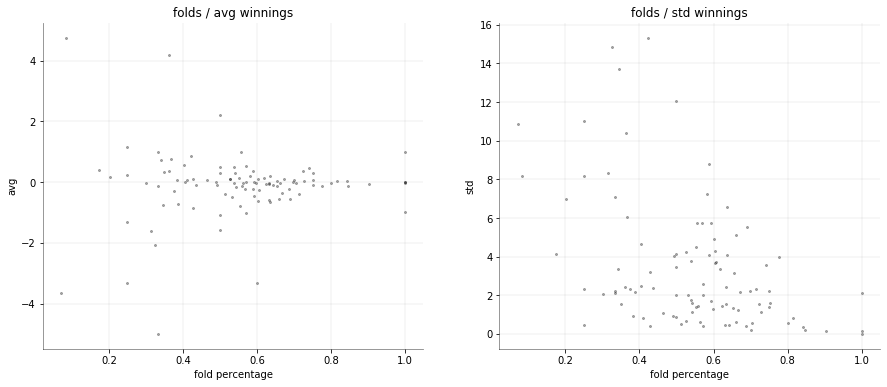

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
setAxConfig(ax1, 'folds / avg winnings', 'fold percentage', 'avg')
setAxConfig(ax2, 'folds / std winnings', 'fold percentage', 'std')

fold_average = action_summary.FOLD / action_summary.all_actions

ax1.scatter(
    fold_average, winnings.mean_won, 
    s=4, c='black', alpha=0.3
);
ax2.scatter(
    fold_average, winnings.std_won,
    s=4, c='black', alpha=0.3
);

We see that folding more slightly decreases deviation while the winnings aproximate 0.

### Raises vs. Winnings
Here as opposed to the latter we will see if being more agressive has any effect on winnings.
As a measure for this we will take player's raise average. <br />
We will also check the effects of raise amount consistency on the winnings. Note that before we applied deviation at the winnings, now we apply it to measure a player's characteristic.

In [19]:
raise_stats = actions.groupby('user_id').apply(
    lambda df: pd.DataFrame(
        data = {
            'num_raise': [len(df[df.action_id == ActionId.RAISE])],
            'avg_raise': [df.amount.mean()],
            'std_raise': [df.amount.std()]
        }
    )
).ungroup()

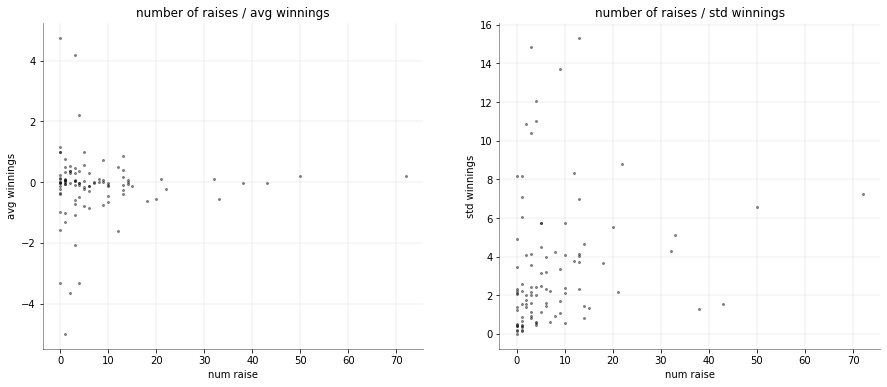

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
setAxConfig(ax1, 'number of raises / avg winnings', 'num raise', 'avg winnings')
setAxConfig(ax2, 'number of raises / std winnings', 'num raise', 'std winnings')

ax1.scatter(
    raise_stats.num_raise[raise_stats.user_id != main_user_id], 
    winnings.mean_won[winnings.user_id != main_user_id], 
    s=4, c='black', alpha=0.4
);
ax2.scatter(
    raise_stats.num_raise[raise_stats.user_id != main_user_id], 
    winnings.std_won[winnings.user_id != main_user_id],
    s=4, c='black', alpha=0.4
);

What is really suprising here is that those few people who raise more frequently gain more on average, though their deviation rises slightly. This is a positive indication that agressive players do win more.

## Agression Based Clustering
We will try to define player's agression level and analyse it further.

### Probability Of Folding To A Raise
Let's see how likely it is for a player to fold after being raised.

In [75]:
folded_to = actions.groupby(
    'round_id'
).apply(
    lambda df: df.sort_values('action_order')
).drop(
    columns = 'round_id'
).ungroup().groupby(
    ['round_id', 'turn']
).apply(
    lambda df: pd.DataFrame(
        data = {
            'user_id': df.user_id,
            'round_id': df.round_id,
            'action_id': df.action_id,
            'folded_to': (df.amount * (
                (df.action_id == ActionId.BET) |
                (df.action_id == ActionId.RAISE)
            )).cumsum()
        }
    )
).ungroup().groupby(
    'user_id'
).apply(
    
)

In [76]:
data = pd.merge(
    folded_to, winnings,
    'outer', 'user_id'
).dropna()

fig, ax = plt.subplots(1, 1, figsize = (10, 6))
setAxConfig(ax, '', '', '')
ax.plot(data.folded_to, )



,index,user_id,round_id,action_id,folded_to
0,0,2,1.0,0.0,0.00
1,1,3,1.0,0.0,0.00
2,2,4,1.0,1.0,0.00
3,3,5,1.0,2.0,4.00
4,4,6,1.0,0.0,4.00
...,...,...,...,...,...
8065,8065,5,1000.0,0.0,2.88
8066,8066,92,1000.0,0.0,2.88
8067,8067,72,1000.0,0.0,2.88
8068,8068,69,1000.0,0.0,2.88


data.folded_to_avg

In [55]:
data.folded_to_avg

0      1.103172
1      2.860000
2      1.380947
3      1.887097
4      1.965385
         ...   
579    0.824000
580    1.504286
581    0.290000
582         NaN
583         NaN
Name: folded_to_avg, Length: 584, dtype: float64

## Predictions
Our goal is to predict players with low action deviation

## 250 Best Players